In [1]:
from models.datasets import MonumentsDataset
from models import datasets
from models.utils import get_train_transform, collate_fn
from models import fasterrcnn
from datasets import class_list
from torch.utils.data import DataLoader

In [2]:
model = fasterrcnn.fasterrcnn_resnet50_fpn(num_classes=17)

In [5]:
import torch
model_path="E:\Major Project\Continual-Monument-Detection\models\saved\model10 (1).pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# weights=torch.load(model_path)

<All keys matched successfully>

In [6]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [17]:
clases=['kiranteshwor mahadev', 'charumati', 'kumaristhan', 'ume_maheshwara', 'jaya bageshwori', 'birupakshya', 'Naxal Bhagwati', 'Krishna_temple _kobahal', 'chakku bakku', 'golden temple', 'Ram Mandir', 'uma maheshwor', 'Maitidevi Temple', 'guyeshwori', 'nagarmandap shree kriti bihar', 'Jalbinayak']

In [18]:
TRAIN_DIR = "E:\Major Project\Continual-Monument-Detection\dataset"
dataset = MonumentsDataset(TRAIN_DIR, 512, 512, clases, get_train_transform())

['IMG20230626113905.jpg', 'IMG20230626113906.jpg', 'IMG20230626113907.jpg', 'IMG20230626113908.jpg', 'IMG20230626113912.jpg']


In [19]:
import torch
indices = torch.randperm(len(dataset)).tolist()
print(len(indices))
print(indices[:20])

8660
[4931, 2614, 3106, 7939, 5759, 2577, 75, 5621, 3477, 7478, 7840, 5566, 6306, 964, 981, 4236, 3269, 2453, 3665, 358]


In [20]:
train_set = torch.utils.data.Subset(dataset, indices[:-500])
eval_set=torch.utils.data.Subset(dataset, indices[-500:])

In [69]:
len(eval_set)

500

In [21]:
valid_loader = DataLoader(
    eval_set,
    batch_size=5,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
    )

In [22]:
original=[]
predicted=[]
imgs=0
with torch.no_grad():
    for batch in valid_loader:
        images, targets = batch
        images = list(image.to('cpu') for image in images)
        imgs+=len(images)
        target = [{k: v.to('cpu') for k, v in t.items()} for t in targets]  
        original.extend(target)
        predictions = model(images)
        predicted.extend(predictions)
print(imgs)

500


In [25]:
print(len(predicted))

500


In [26]:
print(len(original))

500


In [75]:
from torch import tensor
predictions=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],
                     [122.5349, 163.8023, 265.8016, 401.8894],
                     [ 27.4188,  55.2320, 286.0090, 452.0019]]), 
              'labels': tensor([1, 1, 4]),
              'scores': tensor([0.9965, 0.2779, 0.0586])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([12]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676],
                               [106.7353, 121.3933, 373.4354, 412.4706]]),
              'labels': tensor([8, 2]),
              'scores': tensor([0.9917, 0.0847])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447],
                               [146.9601, 165.3507, 469.2495, 417.4515],
                               [ 61.8506,  23.7119, 470.3089, 432.0762],
                               [ 86.0900,  59.0844, 436.2623, 460.5981],
                               [134.8938,  92.4572, 458.3427, 414.5243],
                               [ 36.1431,  89.5182, 480.6086, 381.3042],
                               [140.2368, 103.6454, 453.7489, 434.0392]]),
              'labels': tensor([ 3,  8,  4, 12,  6,  8,  7]),
              'scores': tensor([0.8088, 0.4658, 0.2955, 0.2125, 0.1203, 0.0985, 0.0970])}]


In [60]:
filtered_predictions = []

for pred in predicted:
    scores = pred['scores']
    indices = scores > 0.6
    if indices.any():
        filtered_boxes = pred['boxes'][indices]
        filtered_labels = pred['labels'][indices]
        filtered_scores = pred['scores'][indices]
        filtered_pred = {'boxes': filtered_boxes,
                         'labels': filtered_labels,
                         'scores': filtered_scores}
    else:
        filtered_boxes = torch.tensor([[0, 0, 0, 0]])
        filtered_labels = torch.tensor([0])
        filtered_scores =torch.tensor([1])
        filtered_pred = {'boxes': filtered_boxes,
                         'labels': filtered_labels,
                         'scores': filtered_scores}
    filtered_predictions.append(filtered_pred)
        
true_positives =0
for i, (pred,orig) in enumerate(zip(filtered_predictions,original),1):
    print(f"Prediction {i}:",end='')
    print(f"\t\t\t\t\t\t\tOriginal {i}:")
    print("\tBoxes:",end='')
    print("\t\t\t\t\t\t\tBoxes:")
    print(f"\t{pred['boxes']}",end='')
    print(f"\t{orig['boxes']}")
    print("\tLabels:",end='')
    print("\t\t\t\t\t\t\tLabels:")
    print(f"\t{pred['labels']}",end='')
    
    print(f"\t\t\t\t\t\t{orig['labels']}")
    print("\tScores:")
    print(f"\t{pred['scores']}")
    if(torch.any(pred['labels']==orig['labels'])):
        true_positives+=1
    print()
    
print(f"True Positives={true_positives}")
  
    
    

#     print("\tScores:")
#     print(f"\t{pred['scores']}")
 

Prediction 1:							Original 1:
	Boxes:							Boxes:
	tensor([[192.4746, 226.1393, 307.2162, 312.2948]])	tensor([[187., 224., 302., 312.]])
	Labels:							Labels:
	tensor([2])						tensor([2])
	Scores:
	tensor([0.9936])

Prediction 2:							Original 2:
	Boxes:							Boxes:
	tensor([[156.1375,  82.6115, 401.9650, 390.6196]])	tensor([[149.,  82., 401., 382.]])
	Labels:							Labels:
	tensor([1])						tensor([1])
	Scores:
	tensor([0.9989])

Prediction 3:							Original 3:
	Boxes:							Boxes:
	tensor([[157.2433, 206.4304, 338.0971, 313.7001]])	tensor([[154., 205., 338., 310.]])
	Labels:							Labels:
	tensor([2])						tensor([2])
	Scores:
	tensor([0.9984])

Prediction 4:							Original 4:
	Boxes:							Boxes:
	tensor([[201.0496, 145.1448, 368.5294, 318.4164]])	tensor([[192., 134., 362., 336.]])
	Labels:							Labels:
	tensor([4])						tensor([4])
	Scores:
	tensor([0.9950])

Prediction 5:							Original 5:
	Boxes:							Boxes:
	tensor([[ 71.7909,  27.0965, 426.5257, 462.2668]])	tensor([[ 8

	tensor([[126.3569,  45.7449, 400.6309, 357.8096]])	tensor([[121.,  42., 398., 356.]])
	Labels:							Labels:
	tensor([4])						tensor([4])
	Scores:
	tensor([0.9977])

Prediction 180:							Original 180:
	Boxes:							Boxes:
	tensor([[ 22.3241,  37.3043, 328.5864, 432.4555]])	tensor([[  1.,  33., 339., 418.]])
	Labels:							Labels:
	tensor([1])						tensor([1])
	Scores:
	tensor([0.9968])

Prediction 181:							Original 181:
	Boxes:							Boxes:
	tensor([[115.6617,  34.6530, 402.9615, 370.0157]])	tensor([[113.,  45., 400., 380.]])
	Labels:							Labels:
	tensor([10])						tensor([10])
	Scores:
	tensor([0.9963])

Prediction 182:							Original 182:
	Boxes:							Boxes:
	tensor([[100.3603,   0.0000, 403.4061, 383.4499],
        [128.4138,  67.7351, 323.3334, 378.0071]])	tensor([[ 75.,   1., 379., 444.]])
	Labels:							Labels:
	tensor([10,  7])						tensor([14])
	Scores:
	tensor([0.6950, 0.6503])

Prediction 183:							Original 183:
	Boxes:							Boxes:
	tensor([[154.9667,  78.7798, 359.

	tensor([4])						tensor([4])
	Scores:
	tensor([0.9985])

Prediction 317:							Original 317:
	Boxes:							Boxes:
	tensor([[  8.1594, 136.0768, 351.4505, 345.2338]])	tensor([[ 12., 141., 361., 337.]])
	Labels:							Labels:
	tensor([8])						tensor([8])
	Scores:
	tensor([0.9987])

Prediction 318:							Original 318:
	Boxes:							Boxes:
	tensor([[134.0938, 103.1492, 382.3640, 448.5714]])	tensor([[129.,  80., 392., 456.]])
	Labels:							Labels:
	tensor([3])						tensor([3])
	Scores:
	tensor([0.9984])

Prediction 319:							Original 319:
	Boxes:							Boxes:
	tensor([[115.7388,  46.6136, 371.9398, 429.1773]])	tensor([[113.,  69., 353., 401.]])
	Labels:							Labels:
	tensor([1])						tensor([1])
	Scores:
	tensor([0.9989])

Prediction 320:							Original 320:
	Boxes:							Boxes:
	tensor([[165.6293, 186.8786, 363.0898, 507.4786]])	tensor([[168., 177., 361., 507.]])
	Labels:							Labels:
	tensor([5])						tensor([5])
	Scores:
	tensor([0.9985])

Prediction 321:							Original 321:
	Boxes

	tensor([0.9990])

Prediction 476:							Original 476:
	Boxes:							Boxes:
	tensor([[131.0971,  85.7527, 366.6538, 325.0856]])	tensor([[132.,  87., 367., 323.]])
	Labels:							Labels:
	tensor([6])						tensor([6])
	Scores:
	tensor([0.9959])

Prediction 477:							Original 477:
	Boxes:							Boxes:
	tensor([[113.2100,  13.2316, 400.6071, 369.0865]])	tensor([[113.,  30., 397., 380.]])
	Labels:							Labels:
	tensor([10])						tensor([10])
	Scores:
	tensor([0.9973])

Prediction 478:							Original 478:
	Boxes:							Boxes:
	tensor([[238.3842,  29.2398, 397.4629, 258.8666]])	tensor([[243.,  24., 399., 253.]])
	Labels:							Labels:
	tensor([6])						tensor([6])
	Scores:
	tensor([0.9930])

Prediction 479:							Original 479:
	Boxes:							Boxes:
	tensor([[0, 0, 0, 0]])	tensor([[ 22.,  64., 499., 381.]])
	Labels:							Labels:
	tensor([0])						tensor([15])
	Scores:
	tensor([1])

Prediction 480:							Original 480:
	Boxes:							Boxes:
	tensor([[129.8382,   0.0000, 453.7796, 448.7453]])	te

In [28]:
len(filtered_predictions)

500

In [ ]:
def label_to_class(label):
    return(clases[label])

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix



predicted_boxes = np.array([[95.2413, 136.6463, 384.5086, 407.0092]])
predicted_labels = np.array([8])
original_boxes = np.array([[94., 148., 389., 405.]])
original_labels = np.array([8])

# Step 3: Initialize confusion matrix
num_classes = len(class_names)
conf_matrix = np.zeros((num_classes, num_classes))

# Step 4: Calculate IoU and update confusion matrix
for i in range(len(predicted_boxes)):
    for j in range(len(original_boxes)):
        iou = calculate_iou(predicted_boxes[i], original_boxes[j])
        if iou > 0.5 and predicted_labels[i] == original_labels[j]:
            conf_matrix[predicted_labels[i], predicted_labels[i]] += 1

# Step 5: Visualize confusion matrix (optional)
print(conf_matrix)

# Step 6: Calculate precision, recall, and other metrics (optional)
precision = conf_matrix.diagonal() / conf_matrix.sum(axis=0)
recall = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("Precision:", precision)
print("Recall:", recall)

In [ ]:
targets=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],
                    ]), 
              'labels': tensor([1, ]),
              'scores': tensor([0.9965])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([12]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676]]),
              'labels': tensor([8]),
              'scores': tensor([0.9917])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447]
                              ]),
              'labels': tensor([3]),
              'scores': tensor([0.8088])}]

In [33]:
print(len(original))

500


In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix
from torch import tensor
pred_labels=[]
pred_scores=[]
for pred in filtered_predictions:
#     print(pred['labels'].cpu().numpy())
    label=pred['labels'].cpu().numpy()[0]
    pred_labels.append(label)
#     print(pred['labels'].cpu().numpy())
    
# pred_labels = np.concatenate([pred['labels'].cpu().numpy() for pred in predicted])
count=0
for pred in filtered_predictions:
#     count+=1
#     print(count)
#     print(pred['scores'].cpu().numpy())
    score=pred['scores'].cpu().numpy()[0]
    pred_scores.append(score)
#     print(pred['scores'].cpu().numpy()[0])
# pred_scores = np.concatenate([pred['scores'].cpu().numpy() for pred in predicted])
target_labels = np.concatenate([target['labels'].cpu().numpy() for target in original])
# Threshold the predictions based on scores (keeping only those with scores > 0.6)
threshold = 0.6
print(len(pred_labels))
print(len(target_labels))
# filtered_indices = np.where(pred_scores > threshold)[0]
# pred_labels = pred_labels[filtered_indices]
# Create the confusion matrix
conf_matrix = confusion_matrix(target_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

500
500
Confusion Matrix:
[[18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 49  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 29  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 37  0  0  0  0  0]
 [10  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
 [13  0  0  0  0  0  0  2  0  0  5  0  0  0  0  0]
 [ 7  0  0  4 11  0  0  5  0  2  0  0  0  0  0  0]]


In [57]:
a=tensor([0])
b=a.cpu().numpy()

In [74]:
print(b[0])
c=[]
c.append([2,5])
print(c)
c=c+[10,11]
print(c*10)

0
[[2, 5]]
[[2, 5], 10, 11, [2, 5], 10, 11, [2, 5], 10, 11, [2, 5], 10, 11, [2, 5], 10, 11, [2, 5], 10, 11, [2, 5], 10, 11, [2, 5], 10, 11, [2, 5], 10, 11, [2, 5], 10, 11]


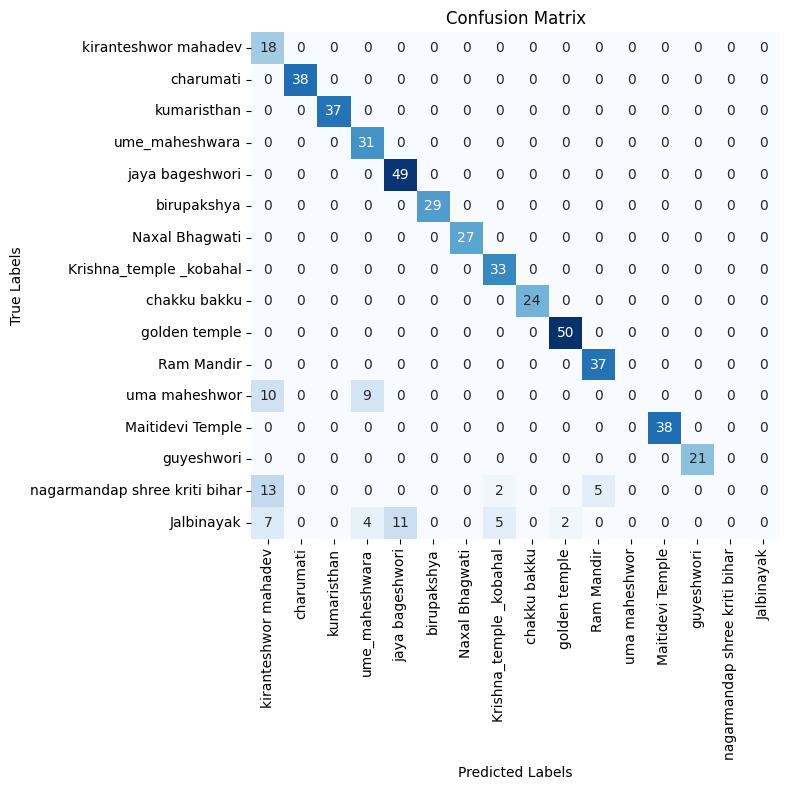

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=None, bbox_inches='tight', format='png')
plt.show()

In [85]:
pred_labels1=[]
pred_scores1=[]
target_labels =[]
for pred in filtered_predictions:
#     print(pred['labels'].cpu().numpy())
    label=pred['labels'].cpu().numpy()[0]
    pred_labels1.append(label)
#     print(pred['labels'].cpu().numpy())
    
# pred_labels = np.concatenate([pred['labels'].cpu().numpy() for pred in predicted])
count=0
# for pred in filtered_predictions:
# #     count+=1
# #     print(count)
# #     print(pred['scores'].cpu().numpy())
#     score=pred['scores'].cpu().numpy()[0]
#     pred_scores1.append(score)
# #     print(pred['scores'].cpu().numpy()[0])
# # pred_scores = np.concatenate([pred['scores'].cpu().numpy() for pred in predicted])
# target_labels = np.concatenate([target['labels'].cpu().numpy() for target in original])
for pred , orig in zip (filtered_predictions,original):
    label=pred['labels'].cpu().numpy()
    print(list(label))
    pred_labels1=pred_labels1+list(label)
    length=(len(label))
    score=pred['scores'].cpu().numpy()
    pred_scores1=pred_scores1+score
    print(length)
    orig=orig['labels'].cpu().numpy()
    target_labels=target_labels+orig*length
    
# Threshold the predictions based on scores (keeping only those with scores > 0.6)
# threshold = 0.6
# print(len(pred_labels))
# print(len(target_labels))
# filtered_indices = np.where(pred_scores > threshold)[0]
# pred_labels = pred_labels[filtered_indices]
# Create the confusion matrix
conf_matrix = confusion_matrix(target_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

[2]
1
[1]
1
[2]
1
[4]
1
[9]
1
[7]
1
[7]
1
[13]
1
[4]
1
[8]
1
[4, 3]


ValueError: operands could not be broadcast together with shapes (0,) (2,) 

In [ ]:
import numpy as np
from sklearn.metrics import  precision_recall_curve
import matplotlib.pyplot as plt

pred_labels = []
pred_scores = []
for pred in filtered_predictions:
    label = pred['labels'].cpu().numpy()[0]
    pred_labels.append(label)

count = 0
for pred in filtered_predictions:
    score = pred['scores'].cpu().numpy()[0]
    pred_scores.append(score)

target_labels = np.concatenate([target['labels'].cpu().numpy() for target in original])

# Threshold the predictions based on scores (keeping only those with scores > 0.6)
threshold = 0.6
filtered_indices = np.where(pred_scores > threshold)[0]
pred_labels = np.array(pred_labels)[filtered_indices]
pred_scores = np.array(pred_scores)[filtered_indices]

# Create the confusion matrix
conf_matrix = confusion_matrix(target_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Create the PR curve
precision, recall, thresholds = precision_recall_curve(target_labels, pred_scores)

# Plot the PR curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()